# Trained Word2Vec model evaluation

The goal of this notebook is to evaluate the country prediction
in a huge dataset with XML files
coming from the SciELO Brazil collection.
The model from the `rf_w2v_200.dump` dump
was applied in that huge dataset of XML files
using the new `w2v_country.py` script, like:

```shell
find * -type f -name '*.xml' \
| xargs -d'\n' -n100 \
  dir/to/w2v_country.py -d dir/to/dictionary_w2v_both.dump \
                        -m dir/to/rf_w2v_200.dump
                        >> rows.csv 2>> error.log
```

That runs the script for each block of $100$ XML files
and saves all the results into the rows.csv file
(a headerless CSV file).
That was applied to several directories
instead of a single `*` as the first `find` argument,
and the several headerless CSV files were joined with a header:

```shell
echo predicted,expected,probability,idx,filename \
| cat - *.csv > 2019-05_w2v_country.csv
```

This `2019-05_w2v_country.csv` is what we'll analyze here.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
pd.options.display.max_rows = 170  # Default is 60

In [3]:
from itertools import groupby
from IPython.display import display_markdown

def display_pairs_as_table(data, columns=5):
    """Function to display a "thin" pd.Series or dict object as a table."""
    pairs = [f"|<b>{k}</b>|{v}" for k, v in data.items()]
    rows = ["".join(pair for idx, pair in grp) + "|"
             for unused, grp in groupby(enumerate(pairs),
                                        key=lambda idx_pair: idx_pair[0] // columns)]
    display_markdown(
        "|&nbsp;" * columns * 2 + "|\n" + "|-" * columns * 2 + "|\n" + "\n".join(rows),
        raw=True,
    )

## Loading the `2019-05_w2v_country.csv` dataset

In [4]:
dataset = pd.read_csv("2019-05_w2v_country.csv")
dataset.head()

,predicted,expected,probability,idx,filename
0,BR,NaN,1.000000,0,aabc/2012nahead/0001-3765-aabc-0613.xml
1,BR,NaN,0.988889,1,aabc/2012nahead/0001-3765-aabc-0613.xml
2,BR,NaN,1.000000,2,aabc/2012nahead/0001-3765-aabc-0613.xml
3,BR,NaN,0.944444,3,aabc/2012nahead/0001-3765-aabc-0613.xml
4,BR,NaN,1.000000,4,aabc/2012nahead/0001-3765-aabc-0613.xml


Not all entries have an "expected" value

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596992 entries, 0 to 596991
Data columns (total 5 columns):
predicted      596992 non-null object
expected       469950 non-null object
probability    596992 non-null float64
idx            596992 non-null int64
filename       596992 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 22.8+ MB


How many (non-empty) XML files built this dataset?

In [6]:
len(dataset["filename"].drop_duplicates())

135285

Most probabilities are quite high
($25\%$ of the data have a probability of $100\%$,
 and $75\%$ of the data have a probability of at least $96.6\%$),
and there's a XML with 771 `<aff>/<contrib>` pairs
(FULL OUTER JOIN).

In [7]:
dataset.describe()

,probability,idx
count,596992.000000,596992.000000
mean,0.935517,3.364730
std,0.147943,17.599814
min,0.077778,0.000000
25%,0.966667,1.000000
50%,0.988889,2.000000
75%,1.000000,4.000000
max,1.000000,771.000000


## Country codes that haven't appeared

These country codes aren't in any prediction result
but appeared as possible "expected" country codes:

In [8]:
possible_codes = dataset["predicted"].unique()
other_codes_count = (
    dataset["expected"]
           [~dataset["expected"].isin(possible_codes)]
    .value_counts()
)
display_pairs_as_table(other_codes_count, columns=11)

|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|<b>SG</b>|55|<b>SY</b>|30|<b>GF</b>|27|<b>KW</b>|21|<b>BJ</b>|20|<b>NP</b>|20|<b>MO</b>|17|<b>ET</b>|15|<b>AZ</b>|13|<b>PH</b>|13|<b>AM</b>|12|
|<b>CI</b>|12|<b>AN</b>|12|<b>TT</b>|10|<b>KE</b>|10|<b>CV</b>|10|<b>QA</b>|9|<b>UR</b>|8|<b>BT</b>|8|<b>AS</b>|7|<b>AF</b>|7|<b>PS</b>|7|
|<b>TU</b>|7|<b>AQ</b>|6|<b>TG</b>|6|<b>MN</b>|6|<b>IS</b>|5|<b>SR</b>|4|<b>SC</b>|4|<b>USA</b>|4|<b>BS</b>|4|<b>original</b>|4|<b>ST</b>|4|
|<b>PG</b>|3|<b>HT</b>|3|<b>ZW</b>|2|<b>Brazil</b>|2|<b>MG</b>|2|<b>BH</b>|2|<b>BB</b>|2|<b>BN</b>|2|<b>GW</b>|2|<b>GN</b>|1|<b>KH</b>|1|
|<b>ML</b>|1|<b>BW</b>|1|<b>YT</b>|1|<b>ND</b>|1|<b>CF</b>|1|<b>MT</b>|1|<b>LA</b>|1|<b>YE</b>|1|<b>KY</b>|1|<b>PF</b>|1|<b> </b>|1|

These are known to have a recall of zero and an undefined precision.
`USA` and `Brazil` aren't country codes and we can fix,
the empty/whitespace string and `original`
we should count as empty country codes.

In [9]:
dataset_fixed = dataset.replace({"expected": {
    "Brazil": "BR",
    "USA": "US",
    " ": None,
    "original": None,
}})
print(dataset_fixed.shape)
dataset_fixed["expected"] \
             [~dataset_fixed["expected"].isin(possible_codes)] \
    .dropna().unique()

(596992, 5)


array(['AM', 'PG', 'KE', 'ND', 'KY', 'SR', 'QA', 'CV', 'ST', 'BT', 'SG',
       'TG', 'IS', 'SY', 'ET', 'TT', 'NP', 'MN', 'PS', 'KW', 'UR', 'GN',
       'BS', 'KH', 'GF', 'CI', 'YE', 'GW', 'AN', 'AF', 'TU', 'AS', 'ML',
       'BJ', 'MG', 'LA', 'PF', 'CF', 'BH', 'MO', 'AZ', 'PH', 'BW', 'ZW',
       'HT', 'MT', 'YT', 'BN', 'AQ', 'SC', 'BB'], dtype=object)

## Prepared dataset with fixed country codes and a filled `expected` value

Let's do the same from the beginning,
but filtering out the rows without the `expected` column
(after fixing the misleading expected values):

In [10]:
dataset_filled = dataset_fixed[~dataset_fixed["expected"].isna()]
dataset_filled.head()

,predicted,expected,probability,idx,filename
1080,BR,BR,0.988889,0,aabc/2015nahead/0001-3765-aabc-20130413.xml
1081,BR,BR,1.000000,1,aabc/2015nahead/0001-3765-aabc-20130413.xml
1082,PT,PT,0.688889,2,aabc/2015nahead/0001-3765-aabc-20130413.xml
1083,PT,PT,0.711111,3,aabc/2015nahead/0001-3765-aabc-20130413.xml
1084,BR,BR,1.000000,0,aabc/2015nahead/0001-3765-aabc-20140231.xml


Number of XML files that had the country code:

In [11]:
len(dataset_filled["filename"].drop_duplicates())

108533

The overall statistics looks almost the same:

In [12]:
dataset_filled.describe()

,probability,idx
count,469945.000000,469945.000000
mean,0.937698,3.253566
std,0.148857,18.189297
min,0.077778,0.000000
25%,0.966667,1.000000
50%,0.988889,2.000000
75%,1.000000,4.000000
max,1.000000,771.000000


## Evaluating all data with known labels (expected country code)

It's not the best way to evaluate the model
since the $23\;815$ XML files used for training it
comes from this dataset.
But now we've applied the model to a dataset
that happens to be about $5$ times bigger than the training dataset,
and not all data from the training dataset had been used for training.
That said, these statistics aren't *clean*,
they might be slightly optimistic.

### Accuracy

What's the overall accuracy for this dataset?

In [13]:
results = dataset_filled["predicted"] == dataset_filled["expected"]
results.mean()

0.9632212280160445

### Precision by country (sorted)

It's a pretty good result, only $3$ countries had a bad precision
(a value below $50\%$).

In [14]:
results_precision = (
    dataset_filled
    .assign(result=results)
    .groupby("predicted")["result"]
    .mean()
    .sort_values()
    .rename("precision")
)
display_pairs_as_table(results_precision, columns=5)

|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|
|-|-|-|-|-|-|-|-|-|-|
|<b>LY</b>|0.1111111111111111|<b>HK</b>|0.26666666666666666|<b>KP</b>|0.45985401459854014|<b>NI</b>|0.6666666666666666|<b>TK</b>|0.6666666666666666|
|<b>KR</b>|0.6676176890156919|<b>TA</b>|0.6923076923076923|<b>NG</b>|0.72|<b>BE</b>|0.7327188940092166|<b>EG</b>|0.7426573426573426|
|<b>GR</b>|0.75|<b>SI</b>|0.7727272727272727|<b>AT</b>|0.7741935483870968|<b>ID</b>|0.782608695652174|<b>ZA</b>|0.7933333333333333|
|<b>NL</b>|0.8174603174603174|<b>CR</b>|0.8181818181818182|<b>CM</b>|0.8333333333333334|<b>TN</b>|0.8415841584158416|<b>GB</b>|0.8469387755102041|
|<b>RS</b>|0.8495145631067961|<b>US</b>|0.8559256390395042|<b>AU</b>|0.8607594936708861|<b>JP</b>|0.8739495798319328|<b>LB</b>|0.88|
|<b>PL</b>|0.8825503355704698|<b>TW</b>|0.8932038834951457|<b>CO</b>|0.9001501501501501|<b>CL</b>|0.9143754909662215|<b>FR</b>|0.9187657430730478|
|<b>CH</b>|0.9222222222222223|<b>DE</b>|0.9247311827956989|<b>CU</b>|0.926829268292683|<b>HR</b>|0.9411764705882353|<b>CA</b>|0.9480286738351255|
|<b>AR</b>|0.9496065942300487|<b>ES</b>|0.9558321132259638|<b>PE</b>|0.9577464788732394|<b>MX</b>|0.9588645657926389|<b>DZ</b>|0.9611650485436893|
|<b>IR</b>|0.9661016949152542|<b>BR</b>|0.967076568860308|<b>CN</b>|0.969962670370692|<b>IN</b>|0.9753801593048516|<b>RO</b>|0.975609756097561|
|<b>SA</b>|0.9757575757575757|<b>EC</b>|0.9761904761904762|<b>UY</b>|0.9771689497716894|<b>PT</b>|0.9832610043397396|<b>TR</b>|0.9854748603351955|
|<b>IT</b>|0.9868995633187773|<b>PK</b>|0.9931682322801024|<b>MY</b>|0.9988726042841037|<b>VN</b>|1.0|<b>NO</b>|1.0|
|<b>NZ</b>|1.0|<b>SW</b>|1.0|<b>OM</b>|1.0|<b>PA</b>|1.0|<b>VE</b>|1.0|
|<b>SZ</b>|1.0|<b>TH</b>|1.0|<b>SD</b>|1.0|<b>SV</b>|1.0|<b>SE</b>|1.0|
|<b>UK</b>|1.0|<b>PR</b>|1.0|<b>SN</b>|1.0|<b>PY</b>|1.0|<b>UG</b>|1.0|
|<b>RU</b>|1.0|<b>SK</b>|1.0|<b>TZ</b>|1.0|<b>SB</b>|1.0|<b>PO</b>|1.0|
|<b>UA</b>|1.0|<b>AE</b>|1.0|<b>MU</b>|1.0|<b>EE</b>|1.0|<b>DO</b>|1.0|
|<b>DK</b>|1.0|<b>CZ</b>|1.0|<b>CY</b>|1.0|<b>CS</b>|1.0|<b>BY</b>|1.0|
|<b>BV</b>|1.0|<b>BO</b>|1.0|<b>BM</b>|1.0|<b>BG</b>|1.0|<b>BF</b>|1.0|
|<b>BD</b>|1.0|<b>BA</b>|1.0|<b>AO</b>|1.0|<b>AL</b>|1.0|<b>AG</b>|1.0|
|<b>FI</b>|1.0|<b>MZ</b>|1.0|<b>GD</b>|1.0|<b>GH</b>|1.0|<b>MK</b>|1.0|
|<b>ME</b>|1.0|<b>MD</b>|1.0|<b>MA</b>|1.0|<b>LU</b>|1.0|<b>LT</b>|1.0|
|<b>LK</b>|1.0|<b>KZ</b>|1.0|<b>JO</b>|1.0|<b>JM</b>|1.0|<b>IQ</b>|1.0|
|<b>IL</b>|1.0|<b>IE</b>|1.0|<b>HU</b>|1.0|<b>HN</b>|1.0|<b>GY</b>|1.0|
|<b>GT</b>|1.0|<b>GE</b>|1.0|<b>ZM</b>|1.0|

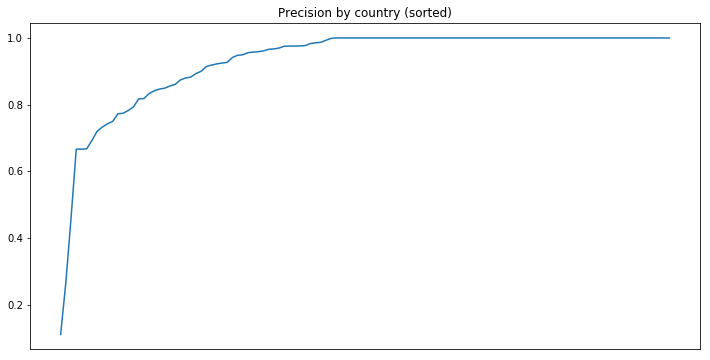

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(results_precision)
ax.set(title="Precision by country (sorted)", xticks=[]);

In [16]:
results_precision.describe()

count    118.000000
mean       0.930194
std        0.139214
min        0.111111
25%        0.919630
50%        1.000000
75%        1.000000
max        1.000000
Name: precision, dtype: float64

We should be careful with the results above,
as it just includes what appeared at least once as a result.

### Recall by country (sorted)

It's a pretty bad result, 

In [17]:
results_recall = (
    dataset_filled
    .assign(result=results)
    .groupby("expected")["result"]
    .mean()
    .sort_values()
    .rename("recall")
)
display_pairs_as_table(results_recall, columns=5)

|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|
|-|-|-|-|-|-|-|-|-|-|
|<b>ZW</b>|0.0|<b>BW</b>|0.0|<b>SY</b>|0.0|<b>MN</b>|0.0|<b>CF</b>|0.0|
|<b>ST</b>|0.0|<b>CI</b>|0.0|<b>SR</b>|0.0|<b>IS</b>|0.0|<b>MO</b>|0.0|
|<b>SG</b>|0.0|<b>MT</b>|0.0|<b>ND</b>|0.0|<b>SC</b>|0.0|<b>CV</b>|0.0|
|<b>HT</b>|0.0|<b>GW</b>|0.0|<b>NP</b>|0.0|<b>QA</b>|0.0|<b>GN</b>|0.0|
|<b>GF</b>|0.0|<b>PS</b>|0.0|<b>PH</b>|0.0|<b>ET</b>|0.0|<b>PF</b>|0.0|
|<b>BT</b>|0.0|<b>ML</b>|0.0|<b>TG</b>|0.0|<b>AF</b>|0.0|<b>LA</b>|0.0|
|<b>YT</b>|0.0|<b>AM</b>|0.0|<b>AN</b>|0.0|<b>AQ</b>|0.0|<b>YE</b>|0.0|
|<b>AS</b>|0.0|<b>BS</b>|0.0|<b>AZ</b>|0.0|<b>UR</b>|0.0|<b>BB</b>|0.0|
|<b>KW</b>|0.0|<b>TU</b>|0.0|<b>TT</b>|0.0|<b>MG</b>|0.0|<b>BH</b>|0.0|
|<b>BJ</b>|0.0|<b>KH</b>|0.0|<b>BN</b>|0.0|<b>KE</b>|0.0|<b>KY</b>|0.0|
|<b>PG</b>|0.0|<b>PR</b>|0.014084507042253521|<b>AO</b>|0.018518518518518517|<b>CZ</b>|0.02|<b>MA</b>|0.027586206896551724|
|<b>LT</b>|0.028169014084507043|<b>JM</b>|0.04|<b>GT</b>|0.05263157894736842|<b>BG</b>|0.05825242718446602|<b>SV</b>|0.058823529411764705|
|<b>UA</b>|0.06349206349206349|<b>PA</b>|0.06382978723404255|<b>JO</b>|0.06451612903225806|<b>CR</b>|0.06818181818181818|<b>CM</b>|0.07042253521126761|
|<b>VN</b>|0.07228915662650602|<b>RU</b>|0.07235142118863049|<b>BO</b>|0.07575757575757576|<b>BM</b>|0.07692307692307693|<b>SZ</b>|0.08333333333333333|
|<b>UK</b>|0.09090909090909091|<b>NG</b>|0.09523809523809523|<b>SN</b>|0.1|<b>DK</b>|0.10365853658536585|<b>NZ</b>|0.10416666666666667|
|<b>ID</b>|0.11688311688311688|<b>GD</b>|0.12|<b>ZM</b>|0.12162162162162163|<b>HR</b>|0.125|<b>LU</b>|0.125|
|<b>EC</b>|0.125|<b>AG</b>|0.125|<b>MZ</b>|0.125|<b>FI</b>|0.12903225806451613|<b>HK</b>|0.13793103448275862|
|<b>PY</b>|0.13934426229508196|<b>SE</b>|0.14049586776859505|<b>CY</b>|0.14457831325301204|<b>NI</b>|0.15384615384615385|<b>IE</b>|0.16363636363636364|
|<b>HU</b>|0.1651376146788991|<b>AE</b>|0.16666666666666666|<b>GE</b>|0.16666666666666666|<b>EE</b>|0.16666666666666666|<b>MK</b>|0.17391304347826086|
|<b>IQ</b>|0.17567567567567569|<b>IL</b>|0.1761006289308176|<b>HN</b>|0.18181818181818182|<b>BV</b>|0.18181818181818182|<b>CH</b>|0.1836283185840708|
|<b>AT</b>|0.18461538461538463|<b>KP</b>|0.1891891891891892|<b>BF</b>|0.2|<b>BA</b>|0.2|<b>PE</b>|0.21587301587301588|
|<b>ME</b>|0.21875|<b>BD</b>|0.22077922077922077|<b>SD</b>|0.2222222222222222|<b>DO</b>|0.2222222222222222|<b>TZ</b>|0.2222222222222222|
|<b>GR</b>|0.2273838630806846|<b>KZ</b>|0.22857142857142856|<b>LY</b>|0.25|<b>AL</b>|0.25|<b>CU</b>|0.25249169435215946|
|<b>NL</b>|0.2641025641025641|<b>RO</b>|0.2955665024630542|<b>UG</b>|0.3076923076923077|<b>DZ</b>|0.308411214953271|<b>MU</b>|0.3333333333333333|
|<b>BY</b>|0.3333333333333333|<b>NO</b>|0.3486238532110092|<b>LB</b>|0.3492063492063492|<b>PL</b>|0.353494623655914|<b>TN</b>|0.3811659192825112|
|<b>JP</b>|0.38733705772811916|<b>OM</b>|0.4166666666666667|<b>ZA</b>|0.41901408450704225|<b>VE</b>|0.4305177111716621|<b>TK</b>|0.4444444444444444|
|<b>SI</b>|0.4594594594594595|<b>GY</b>|0.46153846153846156|<b>TH</b>|0.47543859649122805|<b>BE</b>|0.4937888198757764|<b>LK</b>|0.5|
|<b>AU</b>|0.5271317829457365|<b>TW</b>|0.5411764705882353|<b>GB</b>|0.5868028279654359|<b>UY</b>|0.6079545454545454|<b>SK</b>|0.6486486486486487|
|<b>RS</b>|0.6566604127579737|<b>GH</b>|0.6666666666666666|<b>EG</b>|0.6670854271356784|<b>KR</b>|0.6943620178041543|<b>CA</b>|0.71875|
|<b>DE</b>|0.7392550143266475|<b>SA</b>|0.7840909090909091|<b>IT</b>|0.8287061288632792|<b>US</b>|0.8561909189524253|<b>FR</b>|0.8602594339622641|
|<b>PK</b>|0.8653273809523809|<b>PT</b>|0.8683274021352313|<b>CL</b>|0.8899082568807339|<b>ES</b>|0.8928652837930249|<b>IN</b>|0.8944223107569721|
|<b>MX</b>|0.8953279424977538|<b>TA</b>|0.9|<b>CO</b>|0.9018427980443776|<b>AR</b>|0.9373150887573964|<b>MY</b>|0.9475935828877006|
|<b>IR</b>|0.9612141652613828|<b>TR</b>|0.9676357652221613|<b>CN</b>|0.9867526273955666|<b>BR</b>|0.99871529882253|<b>PO</b>|1.0|
|<b>SW</b>|1.0|<b>CS</b>|1.0|<b>MD</b>|1.0|<b>SB</b>|1.0|

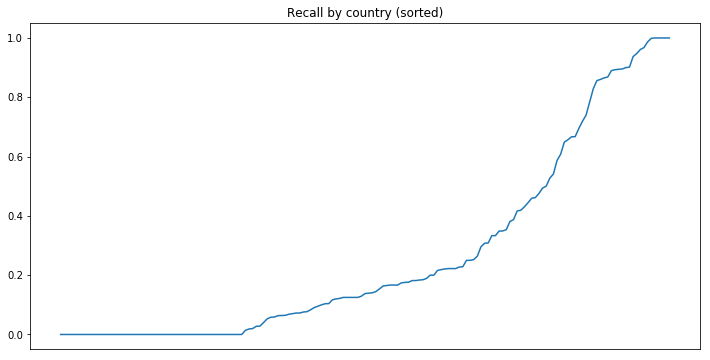

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(results_recall)
ax.set(title="Recall by country (sorted)", xticks=[]);

In [19]:
results_recall.describe()

count    169.000000
mean       0.263977
std        0.318295
min        0.000000
25%        0.000000
50%        0.137931
75%        0.416667
max        1.000000
Name: recall, dtype: float64

Not even $25\%$ of the data had a recall greater than $0.5$.
As it seems, only $10\%$ of the countries are properly modeled,
and the model is useful only for about $20\%$ of the countries.

In [20]:
results_recall.quantile([.8, .85, .9, .95])

0.80    0.510853
0.85    0.688907
0.90    0.872644
0.95    0.955766
Name: recall, dtype: float64

That might sound pessimistic, yet several countries have a quite low support
(i.e., almost no entries)
and many of these weren't included in the training step.

### Precision, Recall and F1 (macro/weighted/micro averages)

The full table of data,
including the *true positives*, *false positives* and *false negatives*
for each country code,
as well as the F1 score:

In [21]:
full_results = pd.DataFrame({
    "tp": dataset_filled[results].groupby("expected").size(),
    "fp": dataset_filled[~results].groupby("predicted").size(),
    "fn": dataset_filled[~results].groupby("expected").size(),
}).fillna(0).astype(int).assign(
    support=lambda df: df["tp"] + df["fn"],
    precision=lambda df: df["tp"] / (df["tp"] + df["fp"]),
    recall=lambda df: df["tp"] / (df["tp"] + df["fn"]),
).assign(
    f1=lambda df: 2 / (1 / df["precision"] + 1 / df["recall"]),
).sort_values(["f1", "support", "tp"], ascending=False)
full_results

,tp,fp,fn,support,precision,recall,f1
SB,7,0,0,7,1.000000,1.000000,1.000000
MD,6,0,0,6,1.000000,1.000000,1.000000
CS,1,0,0,1,1.000000,1.000000,1.000000
PO,1,0,0,1,1.000000,1.000000,1.000000
SW,1,0,0,1,1.000000,1.000000,1.000000
BR,385586,13127,496,386082,0.967077,0.998715,0.982641
CN,11173,346,150,11323,0.969963,0.986753,0.978286
TR,7056,104,236,7292,0.985475,0.967636,0.976474
MY,886,1,49,935,0.998873,0.947594,0.972558
IR,3420,120,138,3558,0.966102,0.961214,0.963652


The F1 score seems ok for $25\%$ of the countries.
$50\%$ of the data has a support smaller or equal to $30$,
whereas $25\%$ of the data has a support of at least $223$,
the main problem we're facing is that our data is unbalanced:

In [22]:
full_results.describe()

,tp,fp,fn,support,precision,recall,f1
count,169.000000,169.000000,169.000000,169.000000,118.000000,169.000000,118.000000
mean,2678.467456,102.272189,102.272189,2780.739645,0.930194,0.263977,0.463593
std,29661.498553,1011.781366,156.937004,29696.213182,0.139214,0.318295,0.301256
min,0.000000,0.000000,0.000000,1.000000,0.111111,0.000000,0.027778
25%,0.000000,0.000000,6.000000,7.000000,0.919630,0.000000,0.220923
50%,4.000000,0.000000,25.000000,30.000000,1.000000,0.137931,0.363636
75%,41.000000,4.000000,141.000000,223.000000,1.000000,0.416667,0.700452
max,385586.000000,13127.000000,962.000000,386082.000000,1.000000,1.000000,1.000000


Macro averages:

In [23]:
full_results_prf1 = full_results[["precision", "recall", "f1"]]
support20 = full_results["support"] >= 20
support50 = full_results["support"] >= 50
support100 = full_results["support"] >= 100
pd.DataFrame({
    "All countries":
        full_results_prf1.mean(),
    "Appeared at least once as a result":
        full_results_prf1.loc[possible_codes].mean(),
    "Support of at least 20":
        full_results_prf1[support20].mean(),
    "Support of at least 50":
        full_results_prf1[support50].mean(),
    "Support of at least 100":
        full_results_prf1[support100].mean(),
}).T

,precision,recall,f1
All countries,0.930194,0.263977,0.463593
Appeared at least once as a result,0.930194,0.378068,0.463593
Support of at least 20,0.925476,0.349505,0.459744
Support of at least 50,0.929699,0.398922,0.487773
Support of at least 100,0.910061,0.489817,0.571874


Weighted averages:

In [24]:
weights = full_results["support"] / full_results["support"].sum()
weights_once = full_results["support"] / full_results.loc[possible_codes]["support"].sum()
weights20 = full_results["support"] / full_results[support20]["support"].sum()
weights50 = full_results["support"] / full_results[support50]["support"].sum()
weights100 = full_results["support"] / full_results[support100]["support"].sum()
pd.DataFrame({
    "All countries":
        full_results_prf1.apply(lambda col: col * weights).sum(),
    "Appeared at least once as a result":
        full_results_prf1.loc[possible_codes].apply(lambda col: col * weights_once).sum(),
    "Support of at least 20":
        full_results_prf1[support20].apply(lambda col: col * weights20).sum(),
    "Support of at least 50":
        full_results_prf1[support50].apply(lambda col: col * weights50).sum(),
    "Support of at least 100":
        full_results_prf1[support100].apply(lambda col: col * weights100).sum()
}).T

,precision,recall,f1
All countries,0.961339,0.963221,0.956628
Appeared at least once as a result,0.962197,0.964081,0.957482
Support of at least 20,0.961845,0.964043,0.957401
Support of at least 50,0.962135,0.964980,0.958239
Support of at least 100,0.962178,0.967459,0.960431


Micro averages:

In [25]:
tf = full_results[["tp", "fp", "fn"]]
tf_mean = tf.mean()
tf_mean_once = tf.loc[possible_codes].mean()
tf_mean20 = tf[support20].mean()
tf_mean50 = tf[support50].mean()
tf_mean100 = tf[support100].mean()
pd.DataFrame({
    "All countries": [
        tf_mean["tp"] / (tf_mean["tp"] + tf_mean["fp"]),
        tf_mean["tp"] / (tf_mean["tp"] + tf_mean["fn"]),
    ],
    "Appeared at least once as a result": [
        tf_mean_once["tp"] / (tf_mean_once["tp"] + tf_mean_once["fp"]),
        tf_mean_once["tp"] / (tf_mean_once["tp"] + tf_mean_once["fn"]),
    ],
    "Support of at least 20": [
        tf_mean20["tp"] / (tf_mean20["tp"] + tf_mean20["fp"]),
        tf_mean20["tp"] / (tf_mean20["tp"] + tf_mean20["fn"]),
    ],
    "Support of at least 50": [
        tf_mean50["tp"] / (tf_mean50["tp"] + tf_mean50["fp"]),
        tf_mean50["tp"] / (tf_mean50["tp"] + tf_mean50["fn"]),
    ],
    "Support of at least 100": [
        tf_mean100["tp"] / (tf_mean100["tp"] + tf_mean100["fp"]),
        tf_mean100["tp"] / (tf_mean100["tp"] + tf_mean100["fn"]),
    ],
}, index=["precision", "recall"]).T.assign(
    f1=lambda df: 2 / (1 / df["precision"] + 1 / df["recall"])
)

,precision,recall,f1
All countries,0.963221,0.963221,0.963221
Appeared at least once as a result,0.963221,0.964081,0.963651
Support of at least 20,0.963245,0.964043,0.963644
Support of at least 50,0.963275,0.964980,0.964127
Support of at least 100,0.963266,0.967459,0.965358


Almost everything is about $96\%$,
but the macro averages,
which should be enhanced in future models.

### Is there any correlation between these results and the support?

From the Pearson correlation coefficient,
we can see that there's only a slight correlation for the recall:

In [26]:
full_results[["precision", "recall", "f1"]].corrwith(full_results["support"])

precision    0.025974
recall       0.206936
f1           0.185238
dtype: float64

But the magnitude of the support is somewhat "explosive",
which might lead us to a misleading comparison.
The correlation of the ranks (Spearman's rank correlation)
should make more sense for us.

In [27]:
full_results[["precision", "recall", "f1"]].corrwith(full_results["support"], method="spearman")

precision   -0.524733
recall       0.607572
f1           0.355484
dtype: float64

The Kendall rank correlation coefficient is another way to compare the ranks:

In [28]:
full_results[["precision", "recall", "f1"]].corrwith(full_results["support"], method="kendall")

precision   -0.360048
recall       0.490448
f1           0.273118
dtype: float64

These results tells us that the recall *rank* follows the support *rank*
(i.e., we can expect a higher recall when we have more entries),
though it's not as strong as it could be.
On the other hand, the negative coefficient for the precision
makes it clear that we can expect a lower precision
when the support gets higher.
That should not be a surprise:
in order to get a precision way higher than the recall,
the uncommon classes should have almost no false positives,
but common classes might have several false positives,
as these won't make much difference for the precision;
but these false positives for a common class
are usually a false negative for an uncommon class,
which pushes its recall down.

### Empty data

Let's analyze the countries predicted to entries
that didn't have an assigned country.

In [29]:
dataset_empty = dataset_fixed[dataset_fixed["expected"].isna()]
dataset_empty.head()

,predicted,expected,probability,idx,filename
0,BR,NaN,1.000000,0,aabc/2012nahead/0001-3765-aabc-0613.xml
1,BR,NaN,0.988889,1,aabc/2012nahead/0001-3765-aabc-0613.xml
2,BR,NaN,1.000000,2,aabc/2012nahead/0001-3765-aabc-0613.xml
3,BR,NaN,0.944444,3,aabc/2012nahead/0001-3765-aabc-0613.xml
4,BR,NaN,1.000000,4,aabc/2012nahead/0001-3765-aabc-0613.xml


There are many files where that happened:

In [30]:
len(dataset_empty["filename"].drop_duplicates())

27398

The number of predictions of each country code:

|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|&nbsp;|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|<b>BR</b>|113584|<b>CN</b>|3391|<b>PT</b>|1525|<b>US</b>|1463|<b>TR</b>|1445|<b>ES</b>|803|<b>AR</b>|773|<b>MX</b>|732|<b>IR</b>|471|<b>CO</b>|374|
|<b>CL</b>|332|<b>FR</b>|308|<b>IT</b>|286|<b>IN</b>|263|<b>CA</b>|141|<b>DE</b>|138|<b>GB</b>|130|<b>AU</b>|121|<b>KR</b>|118|<b>MY</b>|110|
|<b>EG</b>|77|<b>PK</b>|74|<b>SA</b>|47|<b>RS</b>|45|<b>VE</b>|32|<b>GR</b>|32|<b>TW</b>|31|<b>JP</b>|30|<b>UY</b>|29|<b>KP</b>|25|
|<b>TH</b>|24|<b>BE</b>|24|<b>PE</b>|11|<b>ZA</b>|9|<b>RO</b>|8|<b>CH</b>|8|<b>CU</b>|7|<b>NL</b>|6|<b>TN</b>|5|<b>PL</b>|5|
|<b>VN</b>|2|<b>SE</b>|2|<b>NO</b>|1|<b>LB</b>|1|<b>BG</b>|1|<b>IE</b>|1|<b>IL</b>|1|<b>PY</b>|1|

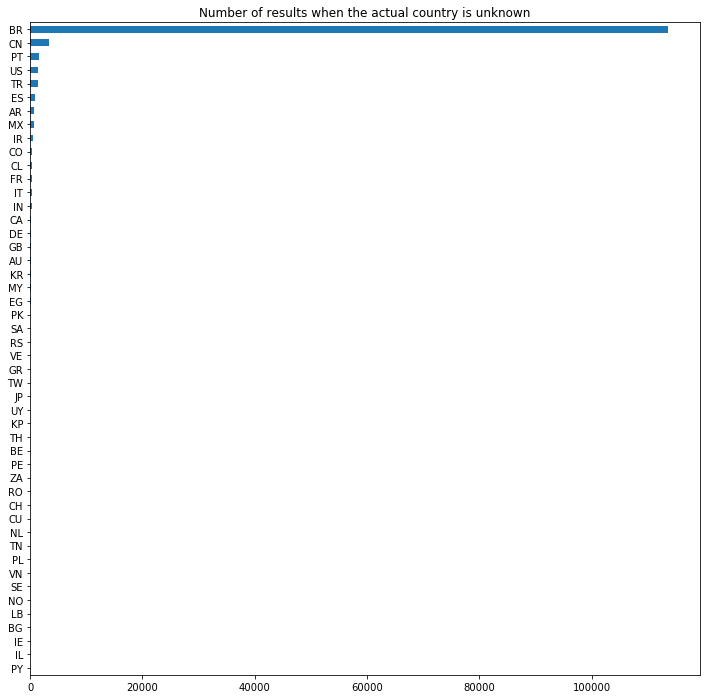

In [31]:
empty_counts = dataset_empty["predicted"].value_counts()
empty_counts[::-1].plot.barh(
    figsize=(12,12),
    title="Number of results when the actual country is unknown",
)
display_pairs_as_table(empty_counts, columns=10)

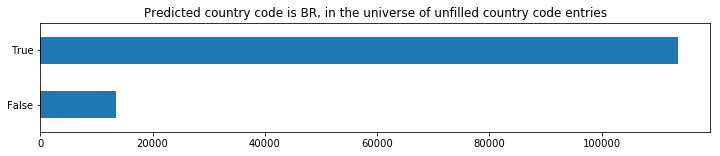

In [32]:
empty_counts.groupby(empty_counts.index == "BR").sum().plot.barh(
    figsize=(12, 2),
    title="Predicted country code is BR, in the universe of unfilled country code entries",
);

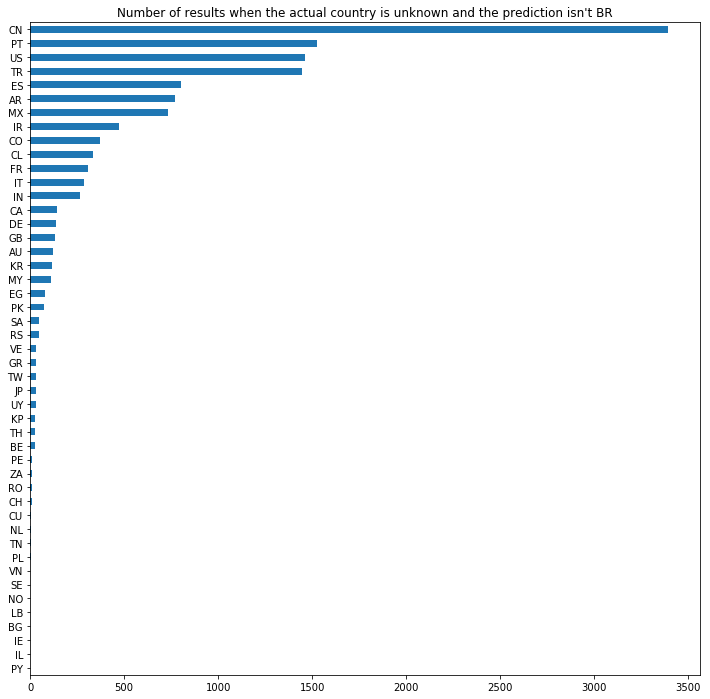

In [33]:
empty_counts[::-1].drop("BR").plot.barh(
    figsize=(12,12),
    title="Number of results when the actual country is unknown and the prediction isn't BR",
);

Does that correlate with the distribution of known country codes?

In [34]:
filled_counts = dataset_filled["expected"].value_counts()
pd.DataFrame({
    method: [empty_counts.corr(filled_counts[empty_counts.index], method=method)]
    for method in ["pearson", "spearman", "kendall"]
}, index=[""])

,pearson,spearman,kendall
,0.999918,0.944252,0.831876


Yes, it's highly correlated with the known data distribution.

Are there any file with both filled and unfilled data?

In [35]:
either_filled_or_unfilled_filenames = pd.concat([
    dataset_fixed["filename"][dataset_fixed["expected"].isna()].drop_duplicates(),
    dataset_fixed["filename"][~dataset_fixed["expected"].isna()].drop_duplicates(),
]).drop_duplicates(keep=False)
dataset_mixed = dataset_fixed[~dataset_fixed["filename"]
                               .isin(either_filled_or_unfilled_filenames)]
dataset_mixed.head(7)

,predicted,expected,probability,idx,filename
1387,BR,BR,0.988889,0,aabc/2015nahead/0001-3765-aabc-201520140133.xml
1388,BR,BR,1.000000,1,aabc/2015nahead/0001-3765-aabc-201520140133.xml
1389,BR,BR,1.000000,2,aabc/2015nahead/0001-3765-aabc-201520140133.xml
1390,BR,NaN,1.000000,3,aabc/2015nahead/0001-3765-aabc-201520140133.xml
6901,CN,CN,0.966667,0,aabc/v87n2/0001-3765-aabc-201520130458.xml
6902,BR,NaN,0.744444,1,aabc/v87n2/0001-3765-aabc-201520130458.xml
6903,BR,NaN,0.722222,2,aabc/v87n2/0001-3765-aabc-201520130458.xml


How many?

In [36]:
len(dataset_mixed["filename"].drop_duplicates())

646

Is the predicted always in the set of expected values for these files?

In [37]:
mixed_sets = dataset_mixed.groupby("filename").apply(
    lambda df: df[["predicted", "expected"]].apply(
        lambda column: frozenset(column.dropna())
    )
)
mixed_sets.groupby(["predicted", "expected"]).size()

predicted                 expected                        
(BR)                      (BR)                                522
                          (BR, PT)                              1
                          (AU)                                  1
                          (BO)                                  1
                          (NL)                                  1
                          (UY, BR)                              1
                          (BW, ZA)                              1
                          (SZ)                                  1
                          (NL, BR)                              1
                          (US, BR)                              1
                          (MX)                                  1
                          (AR)                                  1
                          (CU)                                  1
                          (IN)                                  1
                 

True     563
False     83
dtype: int64

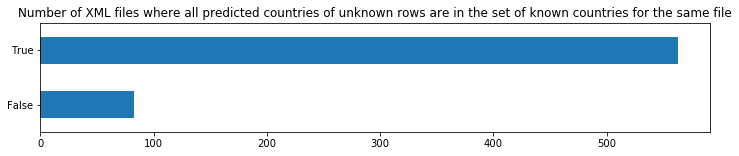

In [38]:
mixed_sets_match = mixed_sets.T.apply(
    lambda row: row["predicted"].issubset(row["expected"])
)
mixed_sets_match_counts = mixed_sets_match.value_counts()
mixed_sets_match_counts[::-1].plot.barh(
    figsize=(12, 2),
    title="Number of XML files where all predicted countries of unknown rows "
          "are in the set of known countries for the same file",
)
mixed_sets_match_counts

Which didn't match? How many files?

In [39]:
mixed_sets.loc[mixed_sets_match.index[~mixed_sets_match]].groupby(["predicted", "expected"]).size()

predicted                 expected                        
(BR)                      (AU)                                1
                          (BO)                                1
                          (NL)                                1
                          (BW, ZA)                            1
                          (SZ)                                1
                          (PT)                                1
                          (CH)                                1
                          (MX)                                1
                          (AR)                                1
                          (CU)                                1
                          (IN)                                1
(DE, BR)                  (BR)                                2
                          (GR)                                2
(CH, HR, US, GB, BR, CA)  (CH, HR, US, GB, CA)                1
(IT, BR)                  (IT)               

These errors suggests the model might be biased towards **BR**,
as in $71$ out of $83$ XML files the included country is Brazil
(remaining inclusions:
 $4\times$ **DE**, $3\times$ **PT**, $2\times$ **GB**/**US**,
 $1\times$ **AR**/**AU**/**CA**/**CL**/**CO**/**MX**;
 $6$ files included two distinct countries),
but the actual data has to be analyzed.
The $83$ XML files are:

In [40]:
set(mixed_sets_match.index[~mixed_sets_match])

{'aa/v14n1-2/1809-4392-aa-14-1-2-0159.xml',
 'aa/v16/1809-4392-aa-16-0327.xml',
 'aa/v24n3-4/1809-4392-aa-24-3-4-0289.xml',
 'aa/v27n1/1809-4392-aa-27-1-0003.xml',
 'aa/v8n4s1/1809-4392-aa-8-4-s1-0305.xml',
 'aabc/v87n2/0001-3765-aabc-201520130458.xml',
 'abcd/v31n4/0102-6720-abcd-31-04-e1410.xml',
 'abmvz/v71n1/0102-0935-abmvz-71-01-00001.xml',
 'abo/v56n2/0004-2749-abo-56-02-0055.xml',
 'abo/v62n3/0004-2749-abo-62-03-0340.xml',
 'ag/v52n2/0004-2803-ag-52-02-129.xml',
 'ag/v52n2/0004-2803-ag-52-02-139.xml',
 'asas/v39n1/1807-8672-asas-39-01-00051.xml',
 'asas/v41/1807-8672-asas-41-e42926.xml',
 'babt/v60/1678-4324-babt-60-e16160240.xml',
 'bcg/v21n3/1982-2170-bcg-21-03-00515.xml',
 'bjid/v20n1/1413-8670-bjid-20-1-0008.xml',
 'bjmbr/2015nahead/1414-431X-bjmbr-1414-431X20154363.xml',
 'bjmbr/2015nahead/1414-431X-bjmbr-1414-431X20154676.xml',
 'bjps/v53n1/2175-9790-bjps-53-01-e15063.xml',
 'bjps/v53n1/2175-9790-bjps-53-01-e16136.xml',
 'bjps/v53n2/2175-9790-bjps-53-02-e15215.xml',
 'bjps

## Evaluating only new data with known country code

Let's evaluate all the statistics for only the files in the dataset
that were not used for training the model.
These are the files we used when training the model:

In [41]:
with open("inner_join_2018-06-04_filenames.txt") as train_filenames_txt_file:
    train_filenames = [line.strip() for line in train_filenames_txt_file]
len(train_filenames)

23815

That's the actual test dataset,
which don't include any file from the training process
(unless they have a copy with another name):

In [42]:
dataset_new = dataset_filled[~dataset_filled["filename"].isin(train_filenames)]
dataset_new.head()

,predicted,expected,probability,idx,filename
1080,BR,BR,0.988889,0,aabc/2015nahead/0001-3765-aabc-20130413.xml
1081,BR,BR,1.000000,1,aabc/2015nahead/0001-3765-aabc-20130413.xml
1082,PT,PT,0.688889,2,aabc/2015nahead/0001-3765-aabc-20130413.xml
1083,PT,PT,0.711111,3,aabc/2015nahead/0001-3765-aabc-20130413.xml
1084,BR,BR,1.000000,0,aabc/2015nahead/0001-3765-aabc-20140231.xml


The training dataset had several empty entries,
but it was already expected that the new dataset would be smaller:

In [43]:
len(dataset_new["filename"].drop_duplicates())

91451

Some statistics are almost the same:

In [44]:
dataset_new.describe()

,probability,idx
count,398945.000000,398945.000000
mean,0.931339,3.378368
std,0.157127,19.696455
min,0.077778,0.000000
25%,0.966667,1.000000
50%,0.988889,2.000000
75%,1.000000,4.000000
max,1.000000,771.000000


### Accuracy

The actual accuracy is slight smaller:

In [45]:
results_new = dataset_new["predicted"] == dataset_new["expected"]
results_new.mean()

0.9574728346012609

### Precision, Recall and F1 (macro/weighted/micro averages)

That's the table of precision, recall and F1 for all classes (country codes).

In [46]:
full_results_new = pd.DataFrame({
    "tp": dataset_new[results_new].groupby("expected").size(),
    "fp": dataset_new[~results_new].groupby("predicted").size(),
    "fn": dataset_new[~results_new].groupby("expected").size(),
}).fillna(0).astype(int).assign(
    support=lambda df: df["tp"] + df["fn"],
    precision=lambda df: df["tp"] / (df["tp"] + df["fp"]),
    recall=lambda df: df["tp"] / (df["tp"] + df["fn"]),
).assign(
    f1=lambda df: 2 / (1 / df["precision"] + 1 / df["recall"]),
).sort_values(["f1", "support", "tp"], ascending=False)
full_results_new

,tp,fp,fn,support,precision,recall,f1
MD,3,0,0,3,1.000000,1.000000,1.000000
BR,325954,12936,474,326428,0.961828,0.998548,0.979844
CN,9755,341,146,9901,0.966224,0.985254,0.975646
TR,6202,101,236,6438,0.983976,0.963343,0.973550
MY,713,1,48,761,0.998599,0.936925,0.966780
IR,3005,117,138,3143,0.962524,0.956093,0.959298
AR,4382,261,336,4718,0.943786,0.928783,0.936225
IN,2283,66,316,2599,0.971903,0.878415,0.922797
PK,1022,8,177,1199,0.992233,0.852377,0.917003
MX,3452,169,462,3914,0.953328,0.881962,0.916257


Several countries have no support at all, and the precision lowered.
The previous estimates were slightly biased,
and this recall looks quite bad,
with $75\%$ of the classes having less than $0.17$.

In [47]:
full_results_new.describe()

,tp,fp,fn,support,precision,recall,f1
count,164.000000,164.000000,164.000000,164.000000,71.000000,163.000000,70.000000
mean,2329.140244,103.451220,103.451220,2432.591463,0.836241,0.169113,0.461073
std,25454.005144,1011.952988,155.625329,25487.331355,0.252455,0.299846,0.342500
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,7.000000,7.000000,0.811767,0.000000,0.123500
50%,0.000000,0.000000,27.000000,29.500000,0.953328,0.000000,0.385673
75%,27.250000,4.250000,143.000000,248.000000,1.000000,0.166155,0.824619
max,325954.000000,12936.000000,946.000000,326428.000000,1.000000,1.000000,1.000000


Macro averages:

In [48]:
possible_codes_new = dataset_new["predicted"].unique()
full_results_new_prf1 = full_results_new[["precision", "recall", "f1"]]
support20_new = full_results_new["support"] >= 20
support50_new = full_results_new["support"] >= 50
support100_new = full_results_new["support"] >= 100
pd.DataFrame({
    "All countries":
        full_results_new_prf1.mean(),
    "Appeared at least once as a result":
        full_results_new_prf1.loc[possible_codes_new].mean(),
    "Support of at least 20":
        full_results_new_prf1[support20_new].mean(),
    "Support of at least 50":
        full_results_new_prf1[support50_new].mean(),
    "Support of at least 100":
        full_results_new_prf1[support100_new].mean(),
}).T

,precision,recall,f1
All countries,0.836241,0.169113,0.461073
Appeared at least once as a result,0.836241,0.393792,0.461073
Support of at least 20,0.869289,0.290097,0.469537
Support of at least 50,0.879245,0.340474,0.494713
Support of at least 100,0.860303,0.443266,0.546739


Weighted averages:

In [49]:
weights_new = full_results_new["support"] / full_results_new["support"].sum()
weights_once_new = full_results_new["support"] / full_results_new.loc[possible_codes_new]["support"].sum()
weights20_new = full_results_new["support"] / full_results_new[support20_new]["support"].sum()
weights50_new = full_results_new["support"] / full_results_new[support50_new]["support"].sum()
weights100_new = full_results_new["support"] / full_results_new[support100_new]["support"].sum()
pd.DataFrame({
    "All countries":
        full_results_new_prf1.apply(lambda col: col * weights_new).sum(),
    "Appeared at least once as a result":
        full_results_new_prf1.loc[possible_codes_new].apply(lambda col: col * weights_once_new).sum(),
    "Support of at least 20":
        full_results_new_prf1[support20_new].apply(lambda col: col * weights20_new).sum(),
    "Support of at least 50":
        full_results_new_prf1[support50_new].apply(lambda col: col * weights50_new).sum(),
    "Support of at least 100":
        full_results_new_prf1[support100_new].apply(lambda col: col * weights100_new).sum()
}).T

,precision,recall,f1
All countries,0.950513,0.957473,0.948548
Appeared at least once as a result,0.955384,0.962379,0.953409
Support of at least 20,0.951605,0.958611,0.949670
Support of at least 50,0.952379,0.959837,0.950825
Support of at least 100,0.953978,0.962719,0.953593


Micro averages:

In [50]:
tf_new = full_results_new[["tp", "fp", "fn"]]
tf_mean_new = tf_new.mean()
tf_mean_once_new = tf_new.loc[possible_codes_new].mean()
tf_mean20_new = tf_new[support20_new].mean()
tf_mean50_new = tf_new[support50_new].mean()
tf_mean100_new = tf_new[support100_new].mean()
pd.DataFrame({
    "All countries": [
        tf_mean_new["tp"] / (tf_mean_new["tp"] + tf_mean_new["fp"]),
        tf_mean_new["tp"] / (tf_mean_new["tp"] + tf_mean_new["fn"]),
    ],
    "Appeared at least once as a result": [
        tf_mean_once_new["tp"] / (tf_mean_once_new["tp"] + tf_mean_once_new["fp"]),
        tf_mean_once_new["tp"] / (tf_mean_once_new["tp"] + tf_mean_once_new["fn"]),
    ],
    "Support of at least 20": [
        tf_mean20_new["tp"] / (tf_mean20_new["tp"] + tf_mean20_new["fp"]),
        tf_mean20_new["tp"] / (tf_mean20_new["tp"] + tf_mean20_new["fn"]),
    ],
    "Support of at least 50": [
        tf_mean50_new["tp"] / (tf_mean50_new["tp"] + tf_mean50_new["fp"]),
        tf_mean50_new["tp"] / (tf_mean50_new["tp"] + tf_mean50_new["fn"]),
    ],
    "Support of at least 100": [
        tf_mean100_new["tp"] / (tf_mean100_new["tp"] + tf_mean100_new["fp"]),
        tf_mean100_new["tp"] / (tf_mean100_new["tp"] + tf_mean100_new["fn"]),
    ],
}, index=["precision", "recall"]).T.assign(
    f1=lambda df: 2 / (1 / df["precision"] + 1 / df["recall"])
)

,precision,recall,f1
All countries,0.957473,0.957473,0.957473
Appeared at least once as a result,0.957473,0.962379,0.959920
Support of at least 20,0.957503,0.958611,0.958057
Support of at least 50,0.957544,0.959837,0.958689
Support of at least 100,0.957538,0.962719,0.960121


The macro average for the recall is pretty bad,
around $0.4$ for the countries that appeared at least once as the result.
New models should emphasize the recall (macro average)
for a defined set of countries.

Everything looks worse, but that's no longer an optimistic result:
that's an analysis of new XML files,
that weren't used for anything during the training process,
not even to build the dictionary.

Nevertheless, this model has micro/weighted averages of $\approx 0.95$
for precision, recall and F1 score.
The accuracy is about $0.957$,
and the overall precision (macro average) is between $0.83$ and $0.88$,
unless undefined.
That's still a great model,
though it's still biased towards the most common countries in the dataset.